In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import seaborn as sns
import random
import matplotlib.colors as mcolors

class NavigationEnvironment:
    def __init__(self, dimensions=100, barrier_ratio=0.3):
        self.dimensions = dimensions
        self.terrain = np.zeros((dimensions, dimensions))
        self.terrain = np.random.choice([0, 1], size=(dimensions, dimensions), 
                                      p=[1-barrier_ratio, barrier_ratio])
        
        while True:
            self.beginning = (random.randint(0, dimensions-1), random.randint(0, dimensions-1))
            self.destination = (random.randint(0, dimensions-1), random.randint(0, dimensions-1))
            if (self.terrain[self.beginning] == 0 and self.terrain[self.destination] == 0 and 
                self.beginning != self.destination):
                break
        
        self.terrain[self.beginning] = 2
        self.terrain[self.destination] = 3
        self.moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        
    def initialize(self):
        return self.beginning
    
    def is_valid_position(self, position):
        return (0 <= position[0] < self.dimensions and 
                0 <= position[1] < self.dimensions and 
                self.terrain[position] != 1)
    
    def execute_move(self, position, move):
        next_position = (position[0] + move[0], position[1] + move[1])
        
        if not self.is_valid_position(next_position):
            return position, -1, True
        
        if next_position == self.destination:
            return next_position, 100, True
        
        return next_position, -1, False



In [4]:
class DynamicProgramming:
    def __init__(self, environment, discount_factor=0.99):
        self.environment = environment
        self.discount_factor = discount_factor
        self.state_values = defaultdict(float)
        self.strategy = {}
        
    def optimize(self, max_cycles=1000, convergence_limit=1e-4):
        start_timestamp = time.time()
        cycles = 0
        
        while cycles < max_cycles:
            max_change = 0
            for i in range(self.environment.dimensions):
                for j in range(self.environment.dimensions):
                    if not self.environment.is_valid_position((i, j)):
                        continue
                    
                    position = (i, j)
                    previous_value = self.state_values[position]
                    
                    move_values = []
                    for move in self.environment.moves:
                        next_position, reward, terminated = self.environment.execute_move(position, move)
                        value = reward + self.discount_factor * self.state_values[next_position]
                        move_values.append(value)
                    
                    self.state_values[position] = max(move_values)
                    self.strategy[position] = self.environment.moves[np.argmax(move_values)]
                    
                    max_change = max(max_change, abs(previous_value - self.state_values[position]))
            
            cycles += 1
            if max_change < convergence_limit:
                break
                
        return time.time() - start_timestamp, cycles



In [ ]:
class QLearning:
    def __init__(self, environment, learning_rate=0.1, discount_factor=0.99, explore_rate=0.1):
        self.environment = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.explore_rate = explore_rate
        self.q_values = defaultdict(lambda: {move: 0.0 for move in environment.moves})
        
    def choose_action(self, state):
        if random.random() < self.explore_rate:
            return random.choice(self.environment.moves)
        return max(self.environment.moves, 
                  key=lambda m: self.q_values[state][m])
    
    def get_best_action(self, state):
        if state not in self.q_values:
            return self.environment.moves[0]  
        return max(self.q_values[state].items(), key=lambda x: x[1])[0]
        
    def train(self, num_episodes=10000):
        start_timestamp = time.time()
        episode_rewards = []
        
        # Initializing Q-values 
        for i in range(self.environment.dimensions):
            for j in range(self.environment.dimensions):
                if self.environment.is_valid_position((i, j)):
                    self.q_values[(i, j)] = {move: 0.0 for move in self.environment.moves}
        
        for episode in range(num_episodes):
            state = self.environment.initialize()
            episode_reward = 0
            terminated = False
            
            while not terminated:
                action = self.choose_action(state)
                next_state, reward, terminated = self.environment.execute_move(state, action)
                
                best_next_value = max(self.q_values[next_state].values())
                target = reward + self.discount_factor * best_next_value
                current = self.q_values[state][action]
                self.q_values[state][action] = current + self.learning_rate * (target - current)
                
                episode_reward += reward
                state = next_state
            
            episode_rewards.append(episode_reward)
                
        return time.time() - start_timestamp, num_episodes, episode_rewards



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Episode 0, Exploration Rate: 0.9999, Best Reward: -15.0
Episode 1000, Exploration Rate: 0.9047, Best Reward: -11.0


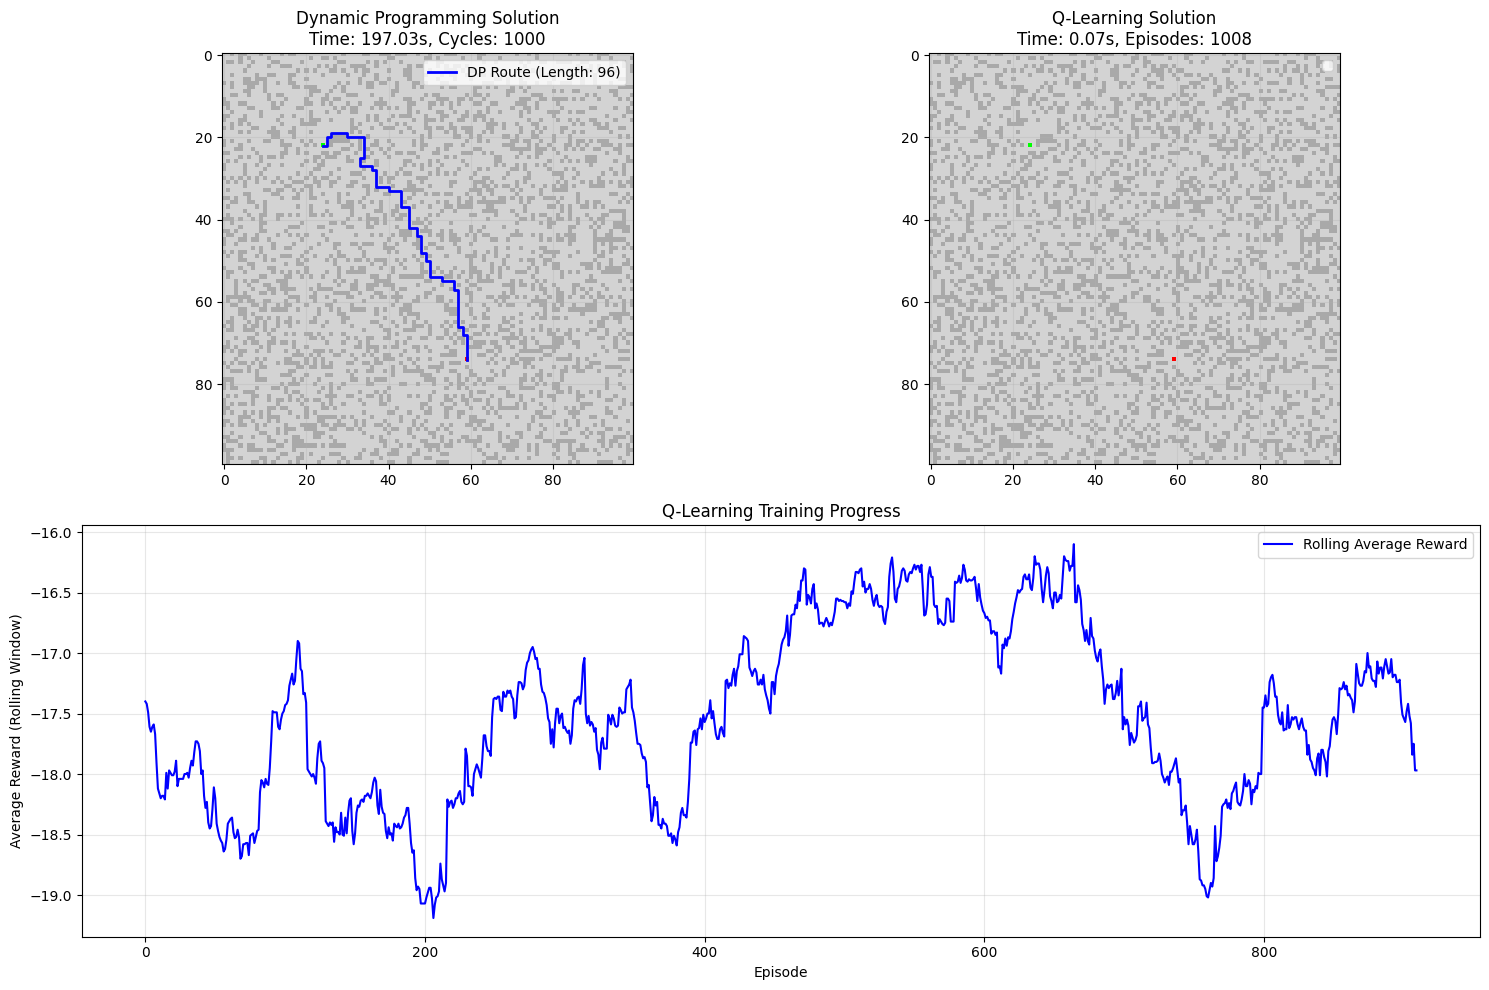


Algorithm Performance Comparison:
Dynamic Programming:
  Route Length: 96
  Convergence Cycles: 1000
  Processing Time: 197.03 seconds

Q-Learning:
  Route Length: inf
  Training Episodes: 1008
  Processing Time: 0.07 seconds


In [ ]:
def calculate_route(environment, strategy_func):
    route = [environment.beginning]
    current = environment.beginning
    visited = {current}
    
    while current != environment.destination:
        if isinstance(strategy_func, dict):
            if current not in strategy_func:
                return None
            move = strategy_func[current]
        else:
            move = strategy_func(current)
            
        next_position = (current[0] + move[0], current[1] + move[1])
        
        if not environment.is_valid_position(next_position) or next_position in visited:
            return None
        
        route.append(next_position)
        visited.add(next_position)
        current = next_position
        
        if len(route) > environment.dimensions * 2:
            return None
    
    return route


environment = NavigationEnvironment(dimensions=100, barrier_ratio=0.3)

# Dynamic Programming Solution
dp_solver = DynamicProgramming(environment)
dp_time, dp_cycles = dp_solver.optimize()
dp_route = calculate_route(environment, dp_solver.strategy)
dp_route_length = len(dp_route) if dp_route else float('inf')

# Q-Learning Solution
q_solver = QLearning(environment)
q_time, q_episodes, rewards = q_solver.train(num_episodes=10000)
q_route = calculate_route(environment, q_solver.get_best_action)
q_route_length = len(q_route) if q_route else float('inf')


colors = ['lightgray', 'darkgray', 'lime', 'red']
cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(15, 10))

# Plotting Dynamic Programming soln
plt.subplot(221)
plt.imshow(environment.terrain, cmap=cmap, interpolation='nearest')
if dp_route:
    route_y, route_x = zip(*dp_route)
    plt.plot(route_x, route_y, color='blue', linewidth=2, 
             label=f'DP Route (Length: {dp_route_length})')
plt.title(f'Dynamic Programming Solution\nTime: {dp_time:.2f}s, Cycles: {dp_cycles}')
plt.grid(True, alpha=0.3)
plt.legend()

# Plotting Q-Learning soln
plt.subplot(222)
plt.imshow(environment.terrain, cmap=cmap, interpolation='nearest')
if q_route:
    route_y, route_x = zip(*q_route)
    plt.plot(route_x, route_y, color='purple', linewidth=2, 
             label=f'Q-Learning Route (Length: {q_route_length})')
plt.title(f'Q-Learning Solution\nTime: {q_time:.2f}s, Episodes: {q_episodes}')
plt.grid(True, alpha=0.3)
plt.legend()

# Plotting Q-Learning rewards
plt.subplot(212)
window_size = 100
rolling_mean = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(rolling_mean, color='blue', label='Rolling Average Reward')
plt.title('Q-Learning Training Progress')
plt.xlabel('Episode')
plt.ylabel('Average Reward (Rolling Window)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print("\nAlgorithm Performance Comparison:")
print("=" * 40)
print("Dynamic Programming:")
print(f"  Route Length: {dp_route_length}")
print(f"  Convergence Cycles: {dp_cycles}")
print(f"  Processing Time: {dp_time:.2f} seconds")
print("\nQ-Learning:")
print(f"  Route Length: {q_route_length}")
print(f"  Training Episodes: {q_episodes}")
print(f"  Processing Time: {q_time:.2f} seconds")
print("=" * 40)